In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from PIL import Image
from torch import optim
import matplotlib.pyplot as plt
import numpy as np

# GOAL:
##### The goal of Style transfer is tp match the content of the content image and style of the style image. This is done by extracting specific features at different layers.

### VGG19 IS SPLIT INTO TWO :

1. vgg19.features which contains the Convolution and Pooling layers

2. vgg19.classifier which contains the Linear layers

In [2]:
# Loading the pretrained VGG Model's features which we will be needing to extract the content and style features from
vgg = models.vgg19(pretrained=True).features

In [3]:
# Checking to see if we've only extracted the features and not the classifier
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
# freezing the parameters 
for param in vgg.parameters():
  param.requires_grad_(False)

### LOADING THE CONTENT AND THE STYLE IMAGES

In [5]:
# Defining a function that will help in Loading images

def img_load (path, max_size = 400, shape=None):

  img = Image.open(path).convert("RGB")
  
  if max(img.size) > max_size:
    size = max_size
  else:
    size = max(img.size)

  if shape is not None:
    size = shape 

  transforms_applied = transforms.Compose([transforms.ToTensor(), transforms.Resize(size)])

  img = transforms_applied(img)[:3,:,:].unsqueeze(0)  
  
  return img

In [6]:
path_content = "/content/5f72b8b8260627ce6fe6a55ae8d8ef01.jpg"
path_style =  "/content/style.jpg"

content = img_load(path_content)
style = img_load(path_style)

In [7]:
# Function to convert the Tensors into Image and displaying them


def img_show(tensor):

  image = tensor.clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image.clip(0,1)

  return image

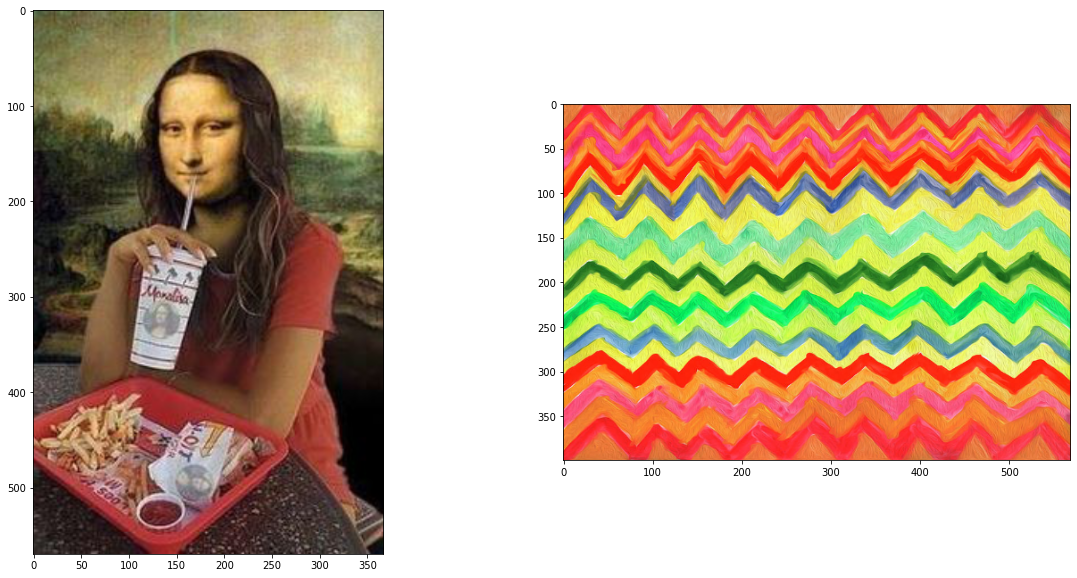

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.imshow(img_show(content))
ax2.imshow(img_show(style))

In [9]:
def get_features(image, model, layers=None):

    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [10]:
def gram_matrix(tensor):

    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(b * d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [11]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True)

In [13]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  1495810.0


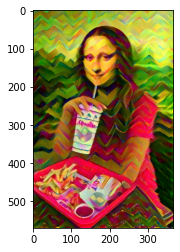

Total loss:  558494.4375


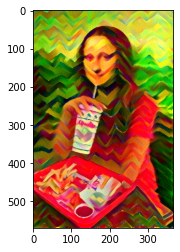

Total loss:  360446.25


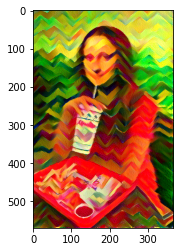

In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(img_show(target))
        plt.show()